In [2]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0
)
response = llm.invoke("What is the capital of France?")
response.pretty_print()

================================== Ai Message ==================================

<think>

</think>

The capital of France is Paris.


In [3]:
from langchain.tools import tool

#### Custom Tools

In [59]:
@tool
def add_numbers(a: float, b: float) -> float:
    """Adds two numbers together."""
    return a + b

@tool
def subtract_numbers(a: float, b: float) -> float:
    """Subtracts the second number from the first."""
    return a - b

@tool
def multiply_numbers(a: float, b: float) -> float:
    """Multiplies two numbers together."""
    return a * b

@tool
def divide_numbers(a: float, b: float) -> float:
    """Divides the first number by the second."""
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b

In [48]:
import yfinance as yf

@tool
def get_stock_price(ticker: str) -> float:
    """Fetches the current stock price for a given ticker symbol."""
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose', None)
        if price is None:
            return f"Could not retrieve stock price for {ticker}. Please check the ticker symbol."
        return f"The current stock price of {ticker} is ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching the stock price: {str(e)}"

#### InBuilt Tools

In [5]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

In [6]:
search.invoke("When will iphone 17 will be released?")

"The launch of the iPhone 17 series will almost certainly be Apple's next hardware release. Here's when it looks like it'll be. Planned for September 2025, the iPhone 17 models could feature larger display sizes, ProMotion across the lineup, Wi-Fi 7, and more. We're still in the middle of the iPhone 16 release cycle, but ... The iPhone 17 series is widely expected to be unveiled in September 2025, following Apple's consistent annual release cadence. If Apple sticks to its usual timeline, the iPhone 17 could be announced during a special event around Tuesday, September 9, with pre-orders opening on Friday, September 12, and the official in-store release likely set for Friday, September 19. These projected dates ... Apple iPhone 17 release date: When will the new smartphones launch? Of all the things that are easy to predict about the iPhone 17, the release date is by far the easiest. Eagerly awaiting the Apple's next iPhone? Here's what we know about the upcoming iPhone 17 line-up so fa

### Tool List

In [49]:
tools = [
    add_numbers,
    subtract_numbers,
    multiply_numbers,
    divide_numbers,
    search,
    get_stock_price
]

### Bind Tools

In [50]:
llm_with_tools = llm.bind_tools(tools)

In [10]:
response = llm_with_tools.invoke(
    "Add 5 and 10, then multiply the result by 2."
    "Also, search for the latest news on AI advancements."
)

In [11]:
response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  add_numbers (y3efgf572)
 Call ID: y3efgf572
  Args:
    a: 5
    b: 10


In [12]:
response.tool_calls

[{'name': 'add_numbers',
  'args': {'a': 5, 'b': 10},
  'id': 'y3efgf572',
  'type': 'tool_call'}]

In [13]:
response = llm_with_tools.invoke(
    "What is the current weather in San Francisco?"
)
response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (0k2v83des)
 Call ID: 0k2v83des
  Args:
    query: current weather San Francisco


### Graph

In [22]:
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

In [23]:
SYSTEM_PROMPT = "You are a helpful assistant that can perform calculations and search the web."

def llm_decision(state: MessagesState) -> str:
    
    user_prompt = state['messages']
    input_prompt = [SYSTEM_PROMPT] + user_prompt
    response = llm_with_tools.invoke(input_prompt)
    return {"messages": [response]}

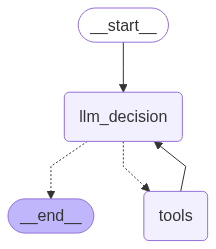

In [60]:
builder = StateGraph(MessagesState)

builder.add_node("llm_decision", llm_decision)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "llm_decision")
builder.add_conditional_edges(
    "llm_decision",
    tools_condition
)
builder.add_edge("tools", "llm_decision")

react_app = builder.compile()

from IPython.display import display, Image
display(Image(react_app.get_graph().draw_mermaid_png()))

In [33]:
for output in react_app.stream(
    {
        "messages": [
            HumanMessage(content="What is 2 times of Elon Musk Networth?")
        ]
    }
):
    for key, value in output.items():
        if key == "messages":
            for message in value:
                print(f"{message.role}: {message.content}")
        else:
            print(f"{key}: {value}")
            print("-" * 20)
        

llm_decision: {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'xnbyyydxy', 'function': {'arguments': '{"query":"Elon Musk net worth"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 264, 'prompt_tokens': 353, 'total_tokens': 617, 'completion_time': 1.141403662, 'prompt_time': 0.022476574, 'queue_time': 0.057979458, 'total_time': 1.163880236}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--089a33c8-4993-484e-a483-7acf396c7496-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Elon Musk net worth'}, 'id': 'xnbyyydxy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 353, 'output_tokens': 264, 'total_tokens': 617})]}
--------------------
tools: {'messages': [ToolMessage(content="Elon Musk on the 2025 The Richest Person In Every State. ... Elon Musk's net worth fell by the equivalent

In [39]:
react_app.invoke({
    "messages":  [HumanMessage(content="What is the speed of light in m/s and multiply with 10?")]
    }
)

{'messages': [HumanMessage(content='What is the speed of light in m/s and multiply with 10?', additional_kwargs={}, response_metadata={}, id='5d0453f1-7dba-4a0b-913b-8cac1cd6bd16'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tggharj3r', 'function': {'arguments': '{"a":299792458,"b":10}', 'name': 'multiply_numbers'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 208, 'prompt_tokens': 357, 'total_tokens': 565, 'completion_time': 0.797300121, 'prompt_time': 0.032557049, 'queue_time': 0.053111971, 'total_time': 0.82985717}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4227d16e-460e-419b-a487-430625f4c59d-0', tool_calls=[{'name': 'multiply_numbers', 'args': {'a': 299792458, 'b': 10}, 'id': 'tggharj3r', 'type': 'tool_call'}], usage_metadata={'input_tokens': 357, 'output_tokens': 208, 'total_tokens': 565}),
  ToolMessage(content='299792458

In [47]:
response = react_app.invoke({
    "messages":  [HumanMessage(content="What is the speed of light in m/s and multiply with 10?")]
    }
)

for output in response['messages']:
    output.pretty_print()

================================ Human Message =================================

What is the speed of light in m/s and multiply with 10?
================================== Ai Message ==================================
Tool Calls:
  multiply_numbers (9txxznks3)
 Call ID: 9txxznks3
  Args:
    a: 299792458
    b: 10
================================= Tool Message =================================
Name: multiply_numbers

2997924580
================================== Ai Message ==================================

The speed of light in meters per second is approximately \(299,792,458 \, \text{m/s}\). When multiplied by 10, the result is:

\[
299,792,458 \times 10 = 2,997,924,580
\]

So, the final answer is:

\[
\boxed{2,\!997,\!924,\!580}
\]


In [67]:
response = react_app.invoke({
    "messages":  [HumanMessage(content="Add 5 to AAPL stock price.")]
    }
)

for output in response['messages']:
    output.pretty_print()

================================ Human Message =================================

Add 5 to AAPL stock price.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (4h13txcj8)
 Call ID: 4h13txcj8
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The current stock price of AAPL is $198.42.
================================== Ai Message ==================================

The current stock price of AAPL is **$198.42**. Adding 5 to this price gives us **$203.42**.


In [71]:
response = react_app.invoke({
    "messages":  [HumanMessage(content="Give AAPL stock price and give latest news of this stock")]
    }
)

for output in response['messages']:
    output.pretty_print()

================================ Human Message =================================

Give AAPL stock price and give latest news of this stock
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (g43634trd)
 Call ID: g43634trd
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The current stock price of AAPL is $198.42.
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (1f9kt0n8n)
 Call ID: 1f9kt0n8n
  Args:
    query: latest news AAPL stock
================================= Tool Message =================================
Name: duckduckgo_search

What's going on at Apple (NASDAQ:AAPL)? Read today's AAPL news from trusted media outlets at MarketBeat. Apple (AAPL) stock was downgraded to Hold from Buy by Needham analysts who said the stock is overvalued amid growing AI competition. Get the latest